<a href="https://colab.research.google.com/github/PaulinaRuizB/Signal_Theory/blob/main/Task_4_PDF_with_KDE%2C_PSD_and_moments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Signal Processing

We analyze a signal composed of one or more cosines corrupted by **Gaussian white noise**, and apply statistical and spectral estimation techniques using Python.

---

### **1. Signal Model**

The signal is defined as:

$$
x(t) = \sum_{k=1}^{K} \cos(2\pi f_k t) + n(t)
$$

- $f_k $: Frequency of the \( k \)-th harmonic (e.g. 50 Hz, 120 Hz, 200 Hz)
- $n(t) \sim \mathcal{N}(0, \sigma^2)$: Gaussian white noise with variance $sigma^2 = 0.1$
- We generate **100 realizations** of this signal.

---

### **2. Sample Mean and Variance**

Let $x_i(t)$ be the $i$-th realization. The **sample mean** and **sample variance** are estimated as:

#### Mean:
$$
\\mu(t) = \\frac{1}{N} \\sum_{i=1}^{N} x_i(t)
$$

#### Variance:
$$
\\sigma^2(t) = \\frac{1}{N} \\sum_{i=1}^{N} (x_i(t) - \\mu(t))^2
$$

Where \( N = 100 \) is the number of realizations.

---

### **3. Power Spectral Density (PSD) Estimation - Welch Method**

We estimate the average **Power Spectral Density** using Welch’s method:

1. Divide the signal into overlapping windows of size `nperseg`.
2. Apply a window function (default: Hanning).
3. Compute the periodogram of each segment.
4. Average the periodograms.

The Welch estimate is:

$$
S_{xx}(f) = \\frac{1}{M} \\sum_{m=1}^{M} P_{xx}^{(m)}(f)
$$

Where:
- \( M \): Number of segments
- \( P_{xx}^{(m)}(f) \): Periodogram of the \( m \)-th segment

We expect a **PSD peak at each harmonic frequency**, and a **flat noise floor** due to the Gaussian noise.

---

### **4. Probability Density Function (PDF) Estimation - Kernel Density Estimation**

We estimate the empirical PDF using **Kernel Density Estimation (KDE)**:

Given a set of data points \( x_1, x_2, ..., x_n \), the KDE is:

$$
\\hat{f}(x) = \\frac{1}{n h} \\sum_{i=1}^{n} K\\left( \\frac{x - x_i}{h} \\right)
$$

Where:
- \( K \) is the kernel function (e.g., Gaussian)
- \( h \) is the bandwidth (controls the smoothness)

In our case, the KDE is applied to **all sample points across the 100 realizations**.

---



## 1. Welch's Method

Welch’s method improves the periodogram by averaging multiple overlapping windowed segments:

- Split the signal into overlapping segments.
- Apply a window function (e.g., Hanning) to each.
- Compute the periodogram of each segment.
- Average them to reduce variance.

Mathematically, the Welch estimate is:

$\hat{P}_{Welch}(f) = \frac{1}{K} \sum_{k=1}^{K} \left| \mathcal{F} \{ x_k(n) \cdot w(n) \} \right|^2$

Where:
- $x_k(n)$ is the k segment,
- $w(n)$ is the window function,
- $\mathcal{F} \{\cdot\}$ denotes the Fourier Transform.


## 2. Periodogram

The periodogram is the squared magnitude of the Fourier Transform of the entire signal:

$\hat{P}_{Periodogram}(f) = \frac{1}{N} \left| \sum_{n=0}^{N-1} x(n) e^{-j2\pi fn/N} \right|^2$

- It has high frequency resolution.
- But also **high variance**, which Welch tries to reduce.

## 3. Multitaper Method

The multitaper method uses several orthogonal tapers (windows) to compute multiple spectral estimates:

- Designed to reduce bias and variance simultaneously.
- Tapers are usually Slepian sequences (DPSS).

$\hat{P}_{MT}(f) = \frac{1}{K} \sum_{k=1}^{K} \left| \mathcal{F} \{ x(n) \cdot v_k(n) \} \right|^2$

Where:
- $v_k(n)$ is the k orthogonal taper.

## 4. Wavelet Transform (CWT)

The Continuous Wavelet Transform (CWT) decomposes the signal into time-frequency space using scaled wavelets:

$W_x(a, b) = \int_{-\infty}^{\infty} x(t) \cdot \psi^* \left( \frac{t - b}{a} \right) dt$

- \(a\): scale (related to frequency)
- \(b\): time shift
- $\psi$: mother wavelet

The **wavelet-based PSD** is obtained as the average squared modulus of wavelet coefficients across time:

$PSD_{Wavelet}(f) \propto \langle |W_x(a(f), b)|^2 \rangle_b$

---


Promts:
- Write Python code to generate a signal composed of one or three cosine waves with fixed frequencies (e.g., 50 Hz, 120 Hz, 200 Hz) and add zero-mean Gaussian white noise with variance 0.1. Repeat this process 100 times and store each realization.
- Compute the pointwise sample mean and variance across the 100 realizations of the noisy signal. Plot the resulting mean signal separately.
- Use the Welch method to estimate the average Power Spectral Density (PSD) across the 100 signal realizations. Make the window length nperseg configurable. Plot the averaged PSD on a logarithmic frequency axis.
- Estimate the amplitude distribution of the signal using Kernel Density Estimation (KDE). Use all samples from all 100 signal realizations. Plot the resulting estimated PDF.
- Add an option to visualize one specific realization of the 100 signals by selecting its index (e.g., signal #50). Plot this signal individually.
- Define variables to control the number of harmonics (1 or 3) and the Welch window size nperseg. Use these variables to adapt the signal and PSD calculation accordingly.


In [11]:
!pip install PyWavelets
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.8 MB/s eta 0:00:00


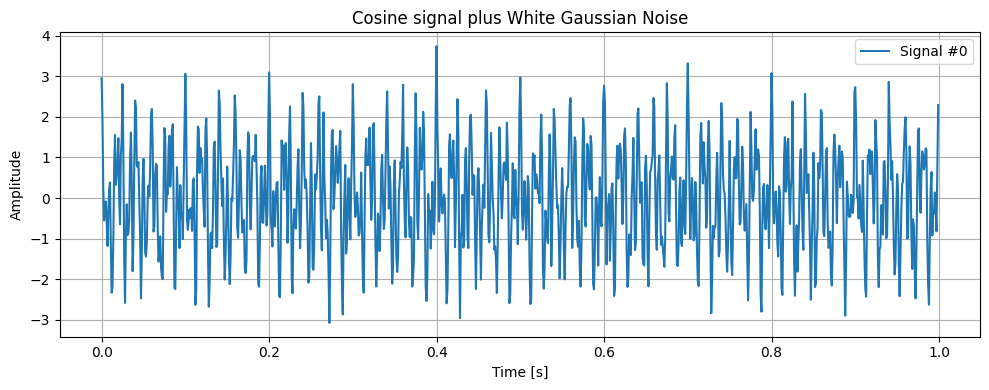

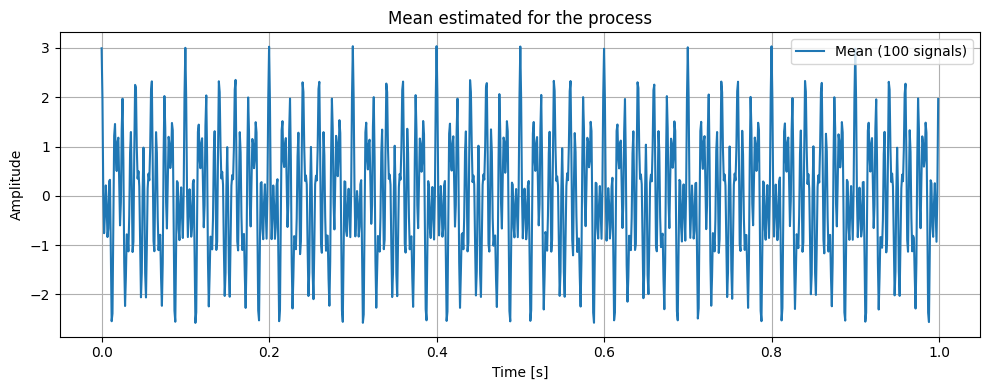

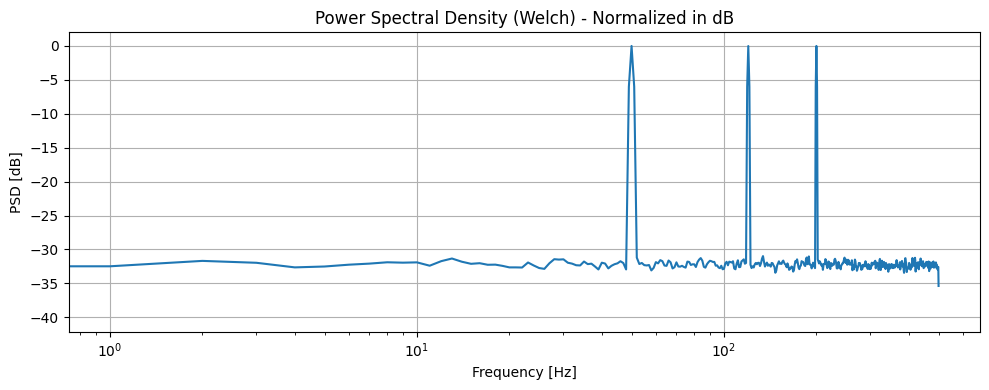

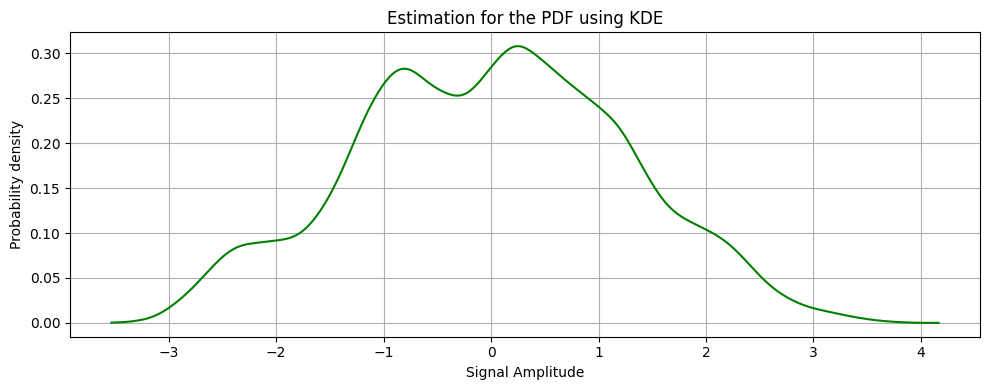

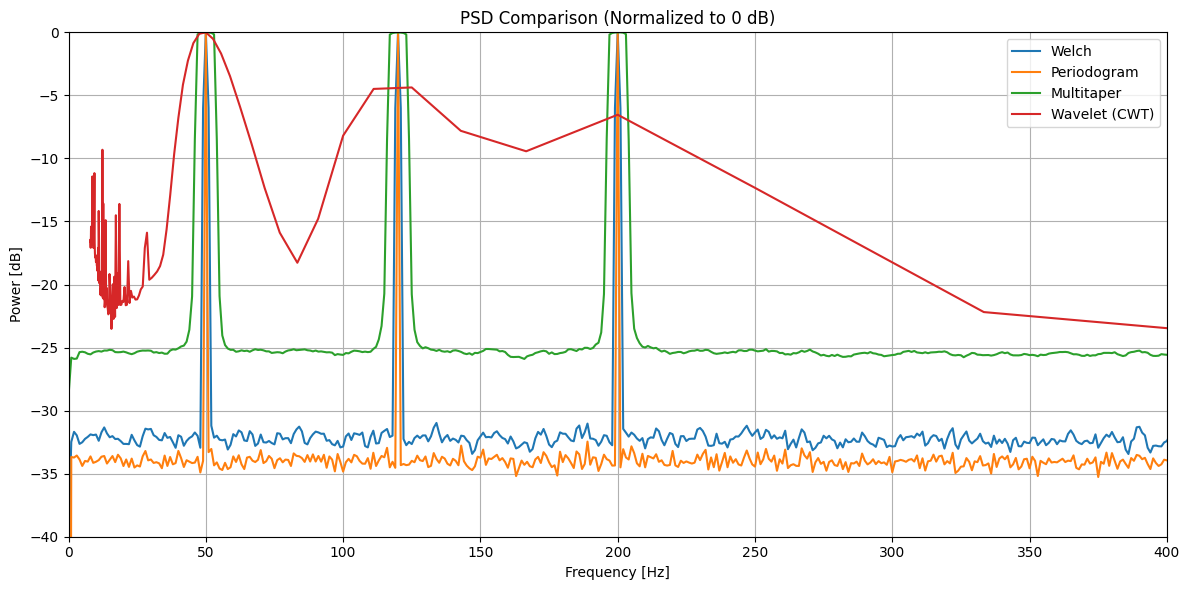

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, periodogram
from scipy.stats import gaussian_kde
import pywt
from mne.time_frequency import psd_array_multitaper

# ---------------------------
# Main functions
# ---------------------------

#generate the signal made of the sum of a cosine and a white gaussian noise
def generate_signals_harmonics(frecs, fs, T, sigma2, num_realizations):
    N = int(fs * T) #Number of samples
    t = np.linspace(0, T, N, endpoint=False) #time vector
    std_dev = np.sqrt(sigma2) #standard deviation
    signals = np.array([
        sum(np.cos(2 * np.pi * f * t) for f in frecs) + np.random.normal(0, std_dev, N)
        for i in range(num_realizations)
    ])
    return signals, t

#compute the mean and variance for the 100 signals
def stadistics(signals):
    mean = np.mean(signals, axis=0)
    variance = np.var(signals, axis=0)
    return mean, variance

#estimate te PSD with the welch function
def estimate_psd_welch(signals, fs, nperseg):
    f, i = welch(signals[0], fs=fs, nperseg=nperseg)
    psd_total = np.zeros_like(i)
    for sig in signals:
        i, Pxx_i = welch(sig, fs=fs, nperseg=nperseg)
        psd_total += Pxx_i
    psd_avg = psd_total / len(signals)
    return f, psd_avg

#estimate the probability density function
def estimate_pdf_kde(signals):
    all_signals = signals.flatten()
    kde = gaussian_kde(all_signals)
    x_vals = np.linspace(min(all_signals), max(all_signals), 500)
    pdf_vals = kde(x_vals)
    return x_vals, pdf_vals

#functions for the comparation of the PSD methods
def estimate_periodogram(signals, fs):
    psds = [periodogram(sig, fs=fs)[1] for sig in signals]
    return np.mean(psds, axis=0), periodogram(signals[0], fs=fs)[0]

def estimate_multitaper(signals, fs):
    psds = [psd_array_multitaper(sig, sfreq=fs, adaptive=True, normalization='full', verbose=0)[0] for sig in signals]
    return np.mean(psds, axis=0), psd_array_multitaper(signals[0], sfreq=fs, adaptive=True, normalization='full', verbose=0)[1]

def estimate_wavelet(signal, fs, wavelet='cmor1.5-1.0'):
    scales = np.arange(1, 128)
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)
    power = np.abs(coeffs)**2
    avg_power = np.mean(power, axis=1)
    return freqs, avg_power

def normalize_to_db(psd):
    psd = np.maximum(psd, 1e-12)  # evitar log(0)
    psd_db = 10 * np.log10(psd / np.max(psd))
    return psd_db

# ---------------------------
# Plot functions
# ---------------------------

def plot_results(t, show_signal, mean, f, Pxx_db, x_pdf, y_pdf, index):

    #plot the selected signal
    plt.figure(figsize=(10, 4))
    plt.plot(t, show_signal, label=f"Signal #{index}")
    plt.title("Cosine signal plus White Gaussian Noise")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Plot for the mean of the 100 signals
    plt.figure(figsize=(10, 4))
    plt.plot(t, mean, label="Mean (100 signals)")
    plt.title("Mean estimated for the process")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #plot for the PSD with welch
    plt.figure(figsize=(10, 4))
    plt.plot(f, Pxx_db)
    plt.title("Power Spectral Density (Welch) - Normalized in dB")
    plt.xlabel("Frequency [Hz]")
    plt.xscale('log')
    plt.ylabel("PSD [dB]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #plot for the PDF
    plt.figure(figsize=(10, 4))
    plt.plot(x_pdf, y_pdf, color='green')
    plt.title("Estimation for the PDF using KDE")
    plt.xlabel("Signal Amplitude")
    plt.ylabel("Probability density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot of the comparation between PSD methods
def plot_psd_comparison(f_welch, psd_welch_db, f_periodo, psd_periodo_db, f_mt, psd_mt_db, freqs_wavelet, psd_wavelet_db):
    plt.figure(figsize=(12, 6))
    plt.plot(f_welch, psd_welch_db, label='Welch')
    plt.plot(f_periodo, psd_periodo_db, label='Periodogram')
    plt.plot(f_mt, psd_mt_db, label='Multitaper')
    plt.plot(freqs_wavelet, psd_wavelet_db, label='Wavelet (CWT)')
    plt.title("PSD Comparison (Normalized to 0 dB)")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(0,400)
    plt.ylim(-40,0)
    plt.ylabel("Power [dB]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------
# Parameters and execution
# ---------------------------
if __name__ == "__main__":
    fs = 1000
    T = 1
    sigma2 = 0.1
    num_realizations = 100
    nperseg = 1024
    use_more_harmonics = True

    frecs = [50, 120, 200] if use_more_harmonics else [50]
    signals, t = generate_signals_harmonics(frecs, fs, T, sigma2, num_realizations)

    mean, variance = stadistics(signals)
    f_welch, Pxx_welch = estimate_psd_welch(signals, fs, nperseg)
    x_pdf, y_pdf = estimate_pdf_kde(signals)

    index = 0
    show_signal = signals[index]

    # PSDs normalizadas en dB
    Pxx_welch_db = normalize_to_db(Pxx_welch)
    psd_periodo, f_periodo = estimate_periodogram(signals, fs)
    psd_periodo_db = normalize_to_db(psd_periodo)
    psd_mt, f_mt = estimate_multitaper(signals, fs)
    psd_mt_db = normalize_to_db(psd_mt)
    freqs_wavelet, psd_wavelet = estimate_wavelet(show_signal, fs)
    psd_wavelet_db = normalize_to_db(psd_wavelet)

    # Plots
    plot_results(t, show_signal, mean, f_welch, Pxx_welch_db, x_pdf, y_pdf, index)
    plot_psd_comparison(f_welch, Pxx_welch_db, f_periodo, psd_periodo_db, f_mt, psd_mt_db, freqs_wavelet, psd_wavelet_db)
